# An Exploratory Analysis of SPY (S&P 500 ETF) Price and Volume Dynamics (2015-2025)

**Abstract:** This study tests the hypothesis that daily price and volume metrics for the S&P 500 over the last 10 years will exhibit minimal correlations, due to unquantified qualitative drivers. While correlation data is expected to be weak, additional analysis should illuminate secondary patterns worth looking into.

## Introduction


Financial time series appear dominated by noise from macroeconomic and behavioral factors. We are exploring whether raw volume and price data for SPY will show any meaningful correlations worth exploring over this 10 year time frame.

**Hypothesis:** We hypothesize that there will not be any significant correlations between the raw price and volume data from the S&P 500 Index(ticker:SPY) from the last 10 years. The share price of the ticker SPY would be an incredibly noisy function if generalized, due to the multitude of qualitative drivers such as macroeconomics, corporate government policy and general financial policy that are beyond the scope of this study. However, I expect to uncover some useful or subtle anomalies worth studying further.

## Imports & Setup

In [695]:
# data handling
import pandas as pd
import numpy as np

#stats and modeling
from scipy.stats import pearsonr, ttest_1samp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from scipy.optimize import curve_fit
from sklearn.base import BaseEstimator,RegressorMixin


#visualizations
import matplotlib.pyplot as plt

## Data Cleaning, Processing, and Feature Engineering


**Source:** Daily SPY Data from June 24th 2015 to June 24th 2025 from Nasdaq, which provided a .CSV file of the historical data with columns "Date", "Close/Last","Volume","Open","High", and "Low". 

**Parsing and Sorting:** 
* Parsed the "Date" column as 'datetime'.
* Sorted all rows in ascending date order.

**Rounding and NA handling:**
* Rounded "Open", "High","Low", and "Close/Last" to two decimal places.
* Dropped any rows with missing values in columns after engineering additional columns.


Added new columns: 

- **MA90:** The moving average of the daily SPY close price.
- **% Change:** The % difference of the current day's price and the previous day.
- **Price Action:** A qualitative indicator of whether the price either "increased" or "decreased" from the previous day.
- **Intraday Range:** The difference between the high and low price within one day.
- **Volume Difference:** The difference between the current day's volume and the previous day's.
- **Volume Trend:** 1 indicates an increasing volume, -1 indicates a  decreasing volume. 
- **Volume Percentile:** The percentile rank of each day's trading volume expressed as a percentile of the full 10 year sample.

These steps ensure our dataset is clean, consistent, and annotated for any exploratory data following.

In [699]:
spy = pd.read_csv("spydata.csv", parse_dates=["Date"])
spy=spy.sort_values("Date")
for col in ["Open","High","Low","Close/Last"]:
    spy[col] = spy[col].round(2)

In [701]:
spy["MA90"] = spy["Close/Last"].rolling(window=90,min_periods=1).mean().round(2)
spy["% Change"]=spy["Close/Last"].pct_change().fillna(0) * 100
spy["Price Action"] = np.where(spy["% Change"] > 0, "increasing",
                      np.where(spy["% Change"] < 0, "decreasing", "no change"))
spy["Intraday Range"] = (spy["High"] - spy["Low"]) 
spy['Volume Difference'] = spy['Volume'] - spy['Volume'].shift(1)
spy['Volume Trend'] = np.sign(spy['Volume Difference']).fillna(0).astype(int)
spy['Volume Percentile'] = spy['Volume'].rank(pct=True)

## Exploratory Data Analysis

Our first exploratory inclination was to check the **total growth** increase of SPY over this ten year period. After calculating the growth:

In [705]:
def total_growth(df: pd.DataFrame,
                 low_col: str,
                 high_col: str,
                 date_col: str = "Date"):
    """Return oldest vs. newest values, difference, and % change."""

    df_sorted = df.sort_values(by=date_col)

    oldest = df_sorted.iloc[0]
    newest = df_sorted.iloc[-1]

    return {
        "oldest": {
            low_col:   oldest[low_col],
            high_col:  oldest[high_col],
        },
        "newest": {
            low_col:   newest[low_col],
            high_col:  newest[high_col],
        },
        "difference": {
            low_col:   newest[low_col] - oldest[low_col],
            high_col:  newest[high_col] - oldest[high_col],
        },
        "pct_change": {
            low_col:   (newest[low_col]  / oldest[low_col]   - 1) * 100,
            high_col:  (newest[high_col] / oldest[high_col]  - 1) * 100,
        },
    }
growth = total_growth(spy, low_col="Low", high_col="High", date_col="Date")

**Total SPY growth over 10 years**
+ Low went from 209.77 to 603.41, while High went from 211.25 to 607.85.
+ Total percent growth for Low is 187.65 while growth for High is 187.74.

This computes to an **average growth rate**(arithmetic) of 18.77% per year over this time frame. By comparison, we were able to find that the **compound annual growth rate** since 1871 of SPY is at 9.19% annually, suggesting SPY's performance is outpacing its historical mean significantly these last 10 years.

The following relationship we wanted to uncover was the relationship between **volume** and **price**, and computing the correlation coefficient between the two variables:

In [709]:
def volume_price_relationship(df,
                              date_col: str = "Date",
                              close_col: str = "Close/Last",
                              low_col: str = "Low",
                              high_col: str = "High",
                              volume_col: str = "Volume"):
    """ for each date, compare to the previous close, the low pct, the high pct, and vol % changes respectively. this will return a new df with the columns corr high and corr low"""
    df2 = df.sort_values(by=date_col).copy()
    df2["prev_close"]  =  df2[close_col].shift(1)
    df2["vol_pct"]  =  df2[volume_col].pct_change() * 100
    df2["low_pct"] = (df2[low_col] - df2["prev_close"]) / df2["prev_close"] * 100
    df2["high_pct"] = (df2[high_col] - df2["prev_close"]) / df2["prev_close"] * 100

    df2 = df2.dropna(subset=["prev_close","vol_pct","low_pct","high_pct"])

    corr_high = df2["vol_pct"].corr(df2["high_pct"])
    corr_low = df2["vol_pct"].corr(df2["low_pct"])

    return df2,corr_high,corr_low

df_analysis,corr_high,corr_low = volume_price_relationship(spy)

**Pearson Correlation**
+ High price vs volume change: r = -0.115
+ Low price vs volume change: r = -0.306

This is a strong signal that volume moves are more strongly associated with downward price action than the upside.

Having identified this noteworthy inverse relationship, the following step was to compute a **correlation matrix** of all raw columns and the engineered columns. We made a decision to drop High and Low from the correlation matrix, assuming Close/Last was representative enough of the price action. The matrix yielded:

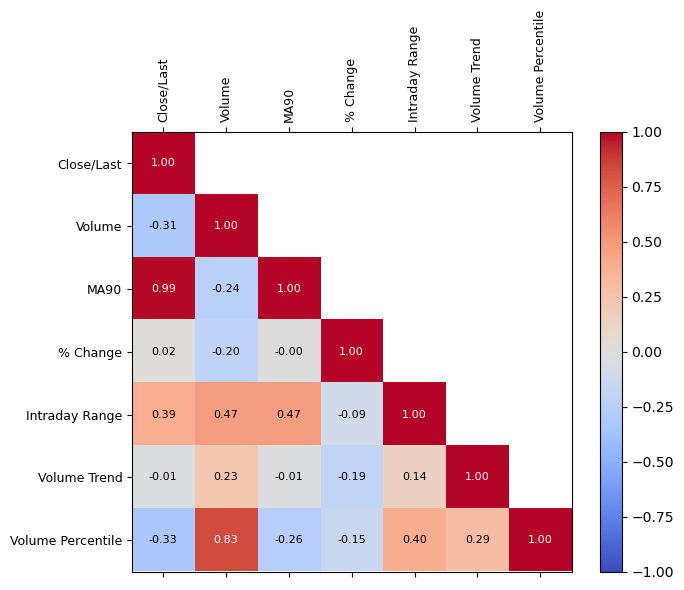

In [713]:
#creating a correlation matrix of all numeric columns (excluding open, high, and low because they represent the price and thus would have near 1.0 correlations with each other. Price at close is a good enough representative), and visualizing it with matplotlib
numeric_col=["Close/Last","Volume","MA90","% Change","Intraday Range","Volume Trend","Volume Percentile"]
cor_matrix=spy[numeric_col].corr()

labels = cor_matrix.columns
data  = cor_matrix.values
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(data, cmap='coolwarm', vmin=-1, vmax=1)

for (i, j), val in np.ndenumerate(data):
    ax.text(j, i, f"{val:.2f}",
            ha='center', va='center',
            fontsize=8,
            color='white' if abs(val) > 0.5 else 'black')


mask = np.triu(np.ones_like(data, dtype=bool), k=1)
data_masked = np.ma.array(data, mask=mask)
ax.clear()
cax = ax.matshow(data_masked, cmap='coolwarm', vmin=-1, vmax=1)
for (i, j), val in np.ndenumerate(data_masked):
    if not mask[i, j]:
        ax.text(j, i, f"{val:.2f}",
                ha='center', va='center',
                fontsize=8,
                color='white' if abs(val) > 0.5 else 'black')


ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=9)
ax.set_yticklabels(labels, fontsize=9)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Many assumptions are made as a result of this matrix calculation, every correlation coefficient below |0.15| are being ignored as **inconclusive**. As the highest coefficient, Volume/Volume Percentile stood out as I expected it to be nearly 1.0. After further investigation, we understood the relationship is non linear due to how the percentile quantity is not magnitude dependent, as changes in scale are not linearly represented when you transform the data into a percentile. The same(but reversed) logic can be applied to Volume/% Change as the correlation is slightly weaker than Volume/% Change but that was not initially expected. The only **conclusive** correlations relating to % Change by our own definition is Volume and Volume Trend, so more statistical information is needed from those variables.

## Statistical Testing

The first test ran was to return the average percent change in SPY price at a high volume threshold, we arbitrarily selected the top 5 percentile to test.  

In [718]:
threshold = spy['Volume'].quantile(0.95)
spike_returns= spy.loc[spy['Volume'] > threshold, '% Change']
t_test,p_value = ttest_1samp(spike_returns, popmean=0)
print(f"Average volume spike day returns: {spike_returns.mean(): },p={p_value:.4f}")

Average volume spike day returns: -0.7369330303067879,p=0.0106


High Volume Returns:

+ the average return on spike days is -0.737%
+ p-value = 0.0106

A p-value of 0.0106 means theres only a 1.06% chance of seeing a sample mean this extreme if the true mean were zero, suggesting the negative return for high volume days is statistically significant. This insight could potentially inform a high volume based trading strategy. The next step is to check the volume return across a full distribution.

In [721]:
#testing the relationship between volume at quantiles x vs the price changes from the previous day
def volume_price_change(spy,
                       volume: str = 'Volume',
                       change: str = '% Change',
                        quantile: float = 0.95,
                        popmean: float = 0.0):
    threshold = spy[volume].quantile(quantile)
    spike = spy.loc[spy[volume]> threshold,change].dropna()
    t_stat,p_value = ttest_1samp(spike,popmean=popmean)
    return {
        'quantile':quantile,
        'threshold':threshold,
        'n_spikes':len(spike),
        'avg_return':spike.mean(),
        't_stat':t_stat,
        'p_value': p_value
    }

for _ in [0.01,0.05,0.25,0.50,0.75,0.95,0.99]:
    res = volume_price_change(spy,quantile=_)
    print(f"Quantile {res['quantile']:.2f}: "
    f"n={res['n_spikes']}, "
    f"avg = {res['avg_return']:.3f}%, ",
    f"t={res['t_stat']:.2f}, "
    f"p={res['p_value']:.4f}")

Quantile 0.01: n=2488, avg = 0.047%,  t=2.03, p=0.0427
Quantile 0.05: n=2388, avg = 0.042%,  t=1.73, p=0.0835
Quantile 0.25: n=1885, avg = 0.011%,  t=0.37, p=0.7084
Quantile 0.50: n=1257, avg = -0.080%,  t=-1.87, p=0.0620
Quantile 0.75: n=629, avg = -0.284%,  t=-3.69, p=0.0002
Quantile 0.95: n=126, avg = -0.737%,  t=-2.59, p=0.0106
Quantile 0.99: n=26, avg = -1.748%,  t=-2.04, p=0.0518


This distribution reveals a consistent negative average return as volume increases, which then drops off dramatically at the extreme high-volume day (≈100th percentile, n=1). Let’s illustrate this with a line plot for clarity, and provide more data:

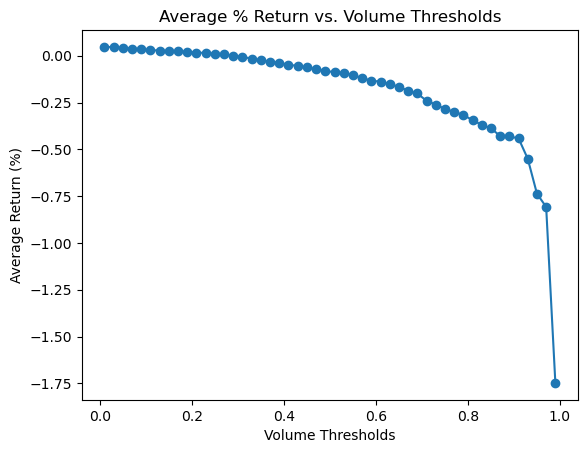

In [724]:
thresholds = np.linspace(0.01,0.99,50)
avg_returns = [volume_price_change(spy,'Volume','% Change',q)['avg_return'] for q in thresholds]


plt.figure()
plt.plot(thresholds, avg_returns, marker='o')
plt.xlabel('Volume Thresholds')
plt.ylabel('Average Return (%)')
plt.title('Average % Return vs. Volume Thresholds')
plt.show()

The relationship is now unmistakable: as trading volume climbs from its lowest levels, the average price return not only declines, but does so at an **accelerating pace**. To model this behavior across the entire volume distribution, we can fit an exponential decay curve using non-linear regression.

## Regression and Modeling

The relationship between Volume Threshold and Average Price Change appears to be exponential in nature, therefore a non-linear(exponential) regression is the first model:

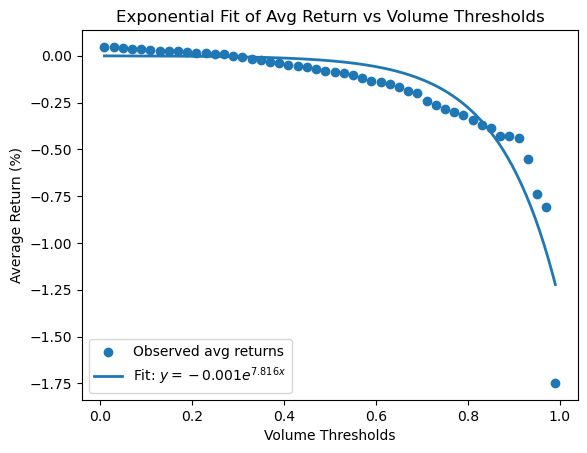

In [729]:
def exp_model(x,a,b):
    return a * np.exp(b*x)

x=np.array(thresholds)
y=np.array(avg_returns)

popt,pcov = curve_fit(exp_model,x,y,p0=(1,1))
a_fit,b_fit=popt

x_fit = np.linspace(x.min(),x.max(),200)
y_fit = exp_model(x_fit,a_fit,b_fit)

plt.figure()
plt.scatter(x,y,label="Observed avg returns")
plt.plot(x_fit, y_fit, label=f"Fit: $y={a_fit:.3f}e^{{{b_fit:.3f}x}}$", linewidth=2)
plt.xlabel("Volume Thresholds")
plt.ylabel("Average Return (%)")
plt.title("Exponential Fit of Avg Return vs Volume Thresholds")
plt.legend()
plt.show()



This curve is usable, but not exactly consistent across all volume thresholds. We will try to use different scikit-learn regressors to model the data instead and check if that yields better results. 

In [744]:
X = np.array(thresholds).reshape(-1,1)
y = np.array(avg_returns)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=14)

class ExpCurve(BaseEstimator, RegressorMixin):
    def __init__(self, p0=(1.0, 1.0)):
        self.p0 = p0
    def _model(self, x, a, b):
        return a * np.exp(b * x)
    def fit(self, X, y):
        x1 = X.ravel()
        popt, pcov = curve_fit(self._model, x1, y, p0=self.p0)
        self.coeffs_ = popt
        return self
    def predict(self, X):
        x1 = X.ravel()
        a, b = self.coeffs_
        return self._model(x1, a, b)

X = np.array(thresholds).reshape(-1,1)
y = np.array(avg_returns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=14
)

base_models = {
    "Linear": LinearRegression(),
    "Poly2": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin",  LinearRegression())
    ]),
    "RF": RandomForestRegressor(n_estimators=200, random_state=14),
    "MLP": MLPRegressor(hidden_layer_sizes=(20,10),
                        learning_rate="adaptive",
                        max_iter=5_000,
                        random_state=14),
    "ExpCurve": ExpCurve(p0=(0.1,1.0))
}
param_grids = {
    "RF":{
        "max_depth": [3,5,8,None],
        "min_samples_leaf":[1,2,5]
    },
    "MLP":{
        "alpha":[1e-4,1e-3,1e-2],
        "hidden_layer_sizes":[(20,10),(50,20)]
    }
}

models = {}
for name, estimator in base_models.items():
    if name in param_grids:
        models[name] = GridSearchCV(
            estimator=estimator,
            param_grid=param_grids[name],
            cv=5,
            scoring="r2",
            n_jobs=-1,
            verbose=1
        )
    else:
        models[name] = estimator

results = []
for name, est in models.items():           
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    results.append({
        "model": name,
        "MSE":   mean_squared_error(y_test, y_pred),
        "R2":    r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).set_index("model")
print(results_df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
               MSE        R2
model                       
Linear    0.012620  0.732970
Poly2     0.009045  0.808621
RF        0.000550  0.988357
MLP       0.039719  0.159554
ExpCurve  0.074674 -0.580074


Contrary to initial expectations, the exponential model was the poorest fit across the entire range of volume, its curve only models extreme tail behavior, the Random Forest regressor delivered the lowest MSE and highest R^2, making it the best performing model. Before proclaiming victory on the model, lets test for over or under fitting, which is optimizing bias vs noise in the data:

In [735]:
print("RF train R²:", r2_score(y_train, models["RF"].predict(X_train)))
print("RF test  R²:", r2_score(y_test,  models["RF"].predict(X_test)))

cv = KFold(n_splits=5, shuffle=True, random_state=14)
scores = cross_val_score(models["RF"], X, y, cv=cv, scoring="r2")
print("RF CV R² scores:", scores, "mean:", scores.mean())

RF train R²: 0.9415684685886687
RF test  R²: 0.9883570572799661
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF CV R² scores: [0.98437781 0.99066461 0.5939243  0.99509096 0.99857929] mean: 0.91252739364814


Overall generalization is strong, as the mean CV of 91 indicates, but it's not exactly the .99 that the model itself outputted. There is high variability in different folds, however, as the model leans heavily on volumes at the extrema.

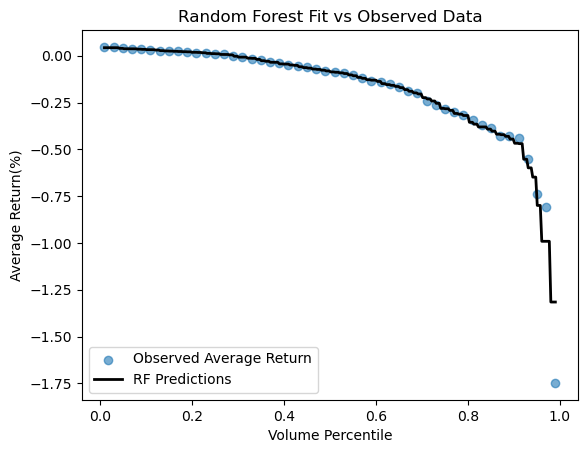

In [739]:
rf_model = models["RF"]
x_grid = np.linspace(X.min(),X.max(),300).reshape(-1,1)
y_grid = rf_model.predict(x_grid)

plt.figure()
plt.scatter(X,y,label="Observed Average Return",alpha=0.6)
plt.plot(x_grid,y_grid,color="black",linewidth=2,label= "RF Predictions")
plt.xlabel("Volume Percentile")
plt.ylabel("Average Return(%)")
plt.title("Random Forest Fit vs Observed Data")
plt.legend()
plt.show()

This tuned Random Forest model gives us a good general idea of the non-linear behavior between volume and % return.

## Results and Interpretation

There are a few key findings to touch on as we wrap up this investigation.

1. Weak Correlations in Raw Data
+ Pearson r of daily volume % and high price = -0.115
+ Pearson r of daily volume % and low price = -0.306

2. Significant Losses on Extreme Volume Days
+ Average return on top 5% volume days: -0.737
+ t-test p-value: 0.0106
+ This could hint that high volatility scares liquidity away from SPY.

3. Return vs Volume Threshold
+ As volume percentile increases, average returns declines slowly until around the 75th percentile, where an exponential fall off happens.
+ Moderate volume days show less obvious decreasing behavior, but the highest volume days have disproportionely negative returns

4. Model Performance
+ Both linear and exponential models fail, as they are too rigid to fit the data properly.
+ Quadratic model captures the curve, but misses the dramatic fall of at extreme values
+ MLP model is too sensitve to extrema
+ Random Forest model performs by far the best

5. Bias vs Variance
+ Training R^2(0.94) and CV R^2(0.91) suggest very mild over-fitting.
+ N fold variability from the middle of the data to the extrema shows instability at average volumes.
+ Overall, model is great at extreme volumes at either end but is less reliable in the middle, just needed to be carefully tuned to not over rely on extrema.   


## Next Steps

1. Testing a volume based strategy


+ Making a general rule to short SPY when volume is extreme

2. Expanding features
    
+ Adding volatility measures, momentum indicators, or macroeconomic factors into the model to make the noise make even more sense.

3. Test of time

+ Using rolling validation methods to make sure the model holds up in different market climates.

4. Model aggregation

+ Blending Random Forest model with models that performed better at average volumes to smooth middle predictions while maintaining extrema accuracy.

5. Deploying an application

+ Building an application that lets users input a volume percentile and output predicted returns.